- https://albertauyeung.github.io/2017/04/23/python-matrix-factorization.html

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import boxcox, inv_boxcox
from scipy import stats

from recommenderSystem import RecSys

# Datios Intelia

In [2]:
!ls data

customers.csv  products.csv  relation.csv


In [3]:
dataPath = "data/"

users = pd.read_csv(dataPath + "customers.csv")
items = pd.read_csv(dataPath + "products.csv")
pairs = pd.read_csv(dataPath + "relation.csv")

/tmp/ipykernel_778/3077265193.py:3: DtypeWarning: Columns (7,9,10,11,12,13,17,18,21,26,27,28,30,36) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv(dataPath + "customers.csv")
/tmp/ipykernel_778/3077265193.py:4: DtypeWarning: Columns (20,32,34,39) have mixed types. Specify dtype option on import or set low_memory=False.
  items = pd.read_csv(dataPath + "products.csv")


# Compañía 1

In [4]:
pairs = pairs[ pairs.company_id == 1].copy()
users = users[ users.company_id == 1].copy()
items = items[ items.company_id == 1].copy()

In [5]:
pairs.sample(4)

,company_id,product_id,customer_id,compras,visto,peso,ultimo
7127,1,42,220420,5,0,15.0,2022-08-02 22:06:53
142,1,1,155470,4,0,12.0,2022-10-16 22:16:57
1514,1,10,45,1,0,3.0,2021-08-19 21:28:52
7881,1,48,116,5,0,15.0,2022-10-07 23:02:54


### Solo hay compras (no hay visitas)

In [6]:
pairs[pairs.visto>0]

,company_id,product_id,customer_id,compras,visto,peso,ultimo


# Definir peso usuario-producto

Mean: 4.1120876545007095
Median: 4.375
Std: 0.7686478068419343


<AxesSubplot:ylabel='Frequency'>

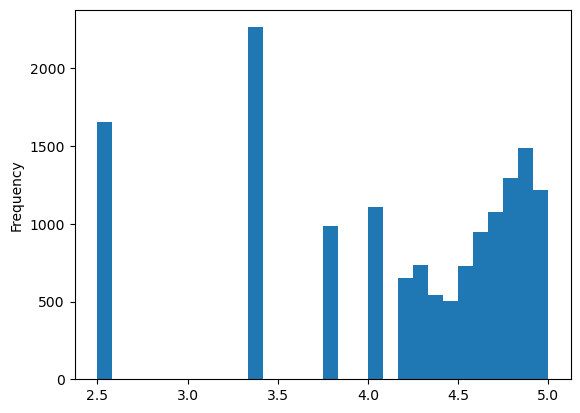

In [7]:
def funcRacional_visitas(x):
    return (1 * x) / (x + 5)

def funcRacional_compras(x):
    return (5 * x) / (x + 1)

def getPeso(col_compras, col_visitias):
    return funcRacional_compras(col_compras + funcRacional_visitas(col_visitias) ).copy()

pairs["peso"] = getPeso(pairs["compras"], pairs["visto"])

print("Mean:",   pairs["peso"].mean())
print("Median:", pairs["peso"].median())
print("Std:",    pairs["peso"].std())

pairs["peso"].plot.hist(bins=30)

# Compañia 1

Number of users: 316
Number of items: 297
Number of interactions: 15204


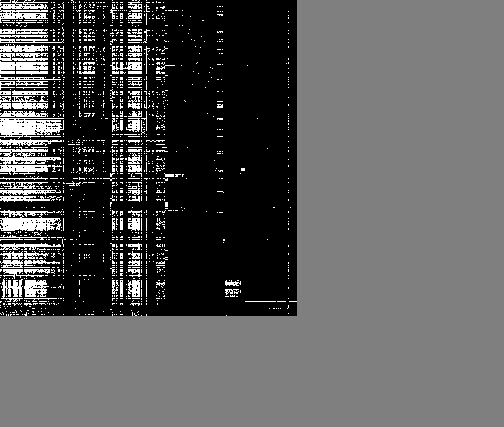

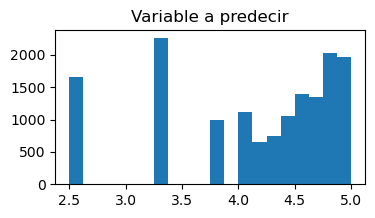

In [8]:
rs = RecSys(pairs, users, items, userName="customer_id", itemName="product_id", scoreName="peso")
rs.draw_matrix()

## Train with fast.ai

In [9]:
from fastai.tabular.all import *
from fastai.collab import *

dls = CollabDataLoaders.from_df(ratings=pairs,
                                valid_pct=0.2,
                                user_name="customer_id",
                                item_name="product_id",
                                rating_name="peso",
                                seed=None,
                                bs=64)

learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), metrics=[mae])
learn.fit_one_cycle(5, 0.005, wd=0.1)

epoch,train_loss,valid_loss,mae,time
0,0.939834,0.352609,0.428379,00:00
1,0.302630,0.294822,0.398631,00:00
2,0.248565,0.271550,0.381417,00:00
3,0.221968,0.258197,0.369266,00:00
4,0.193653,0.257533,0.369097,00:00


In [10]:
u = learn.u_weight
u.weight

Parameter containing:
tensor([[ 0.0048, -0.0079, -0.0018,  ..., -0.0117, -0.0032,  0.0090],
        [-0.0395,  0.0227, -0.0967,  ..., -0.0647, -0.0083, -0.0338],
        [-0.0217, -0.0061,  0.0100,  ...,  0.0077, -0.0195, -0.0115],
        ...,
        [-0.0363,  0.0224, -0.0427,  ..., -0.0330,  0.0250, -0.0002],
        [-0.1156,  0.0729, -0.0517,  ..., -0.0512,  0.0294, -0.0517],
        [-0.0118, -0.0014,  0.0079,  ..., -0.0015,  0.0034, -0.0177]],
       device='cuda:0', requires_grad=True)

In [11]:
learn.bias

<bound method EmbeddingDotBias.bias of EmbeddingDotBias(
  (u_weight): Embedding(314, 50)
  (i_weight): Embedding(280, 50)
  (u_bias): Embedding(314, 1)
  (i_bias): Embedding(280, 1)
)>

In [13]:
learn.u_bias

Embedding(314, 1)

## Train with my module

In [42]:
split_idx = int(len(rs.samples) * 0.8)
#np.random.shuffle(self.samples)
train_samples = rs.samples[:split_idx]
valid_samples = rs.samples[split_idx:]

train_log = rs.entrenar_modelo_manualmente(
    train_samples = train_samples,
    valid_samples = valid_samples,
    embSize = 50,
    lr = 0.01,
    wd = 0.1,
    epochs=50)

Epoch: 1 ; trMAE = 0.8466 trMSE = 0.9880 valMAE = 1.1761 valMSE = 1.7383
Epoch: 2 ; trMAE = 0.7393 trMSE = 0.7954 valMAE = 1.1466 valMSE = 1.7230
Epoch: 3 ; trMAE = 0.6867 trMSE = 0.7084 valMAE = 1.1290 valMSE = 1.7243
Epoch: 4 ; trMAE = 0.6566 trMSE = 0.6602 valMAE = 1.1188 valMSE = 1.7287
Epoch: 5 ; trMAE = 0.6360 trMSE = 0.6290 valMAE = 1.1138 valMSE = 1.7360
Epoch: 6 ; trMAE = 0.6245 trMSE = 0.6082 valMAE = 1.1080 valMSE = 1.7350
Epoch: 7 ; trMAE = 0.6147 trMSE = 0.5923 valMAE = 1.1040 valMSE = 1.7366
Epoch: 8 ; trMAE = 0.6071 trMSE = 0.5799 valMAE = 1.1005 valMSE = 1.7348
Epoch: 9 ; trMAE = 0.6019 trMSE = 0.5706 valMAE = 1.0969 valMSE = 1.7319
Epoch: 10 ; trMAE = 0.5974 trMSE = 0.5623 valMAE = 1.0947 valMSE = 1.7302
Epoch: 11 ; trMAE = 0.5937 trMSE = 0.5554 valMAE = 1.0920 valMSE = 1.7278
Epoch: 12 ; trMAE = 0.5895 trMSE = 0.5489 valMAE = 1.0905 valMSE = 1.7270
Epoch: 13 ; trMAE = 0.5861 trMSE = 0.5431 valMAE = 1.0883 valMSE = 1.7232
Epoch: 14 ; trMAE = 0.5825 trMSE = 0.5370 valMA

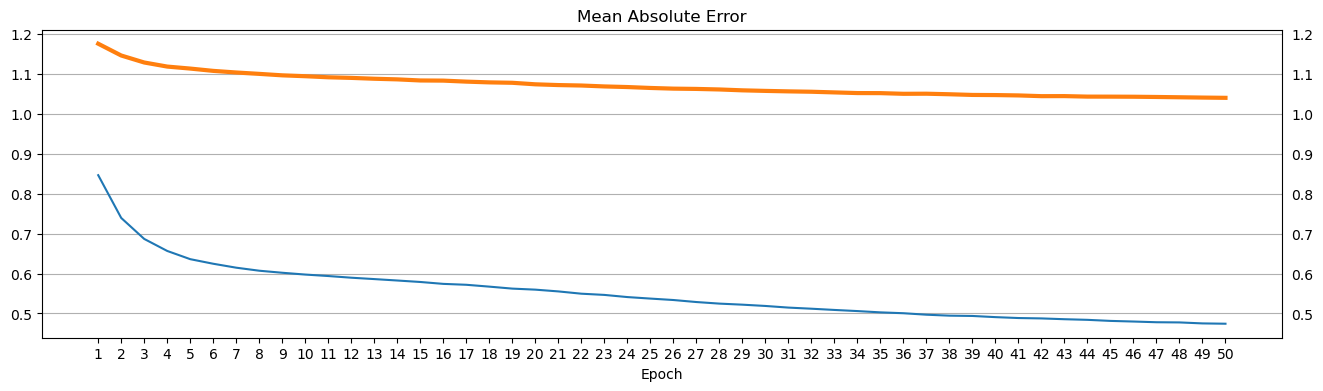

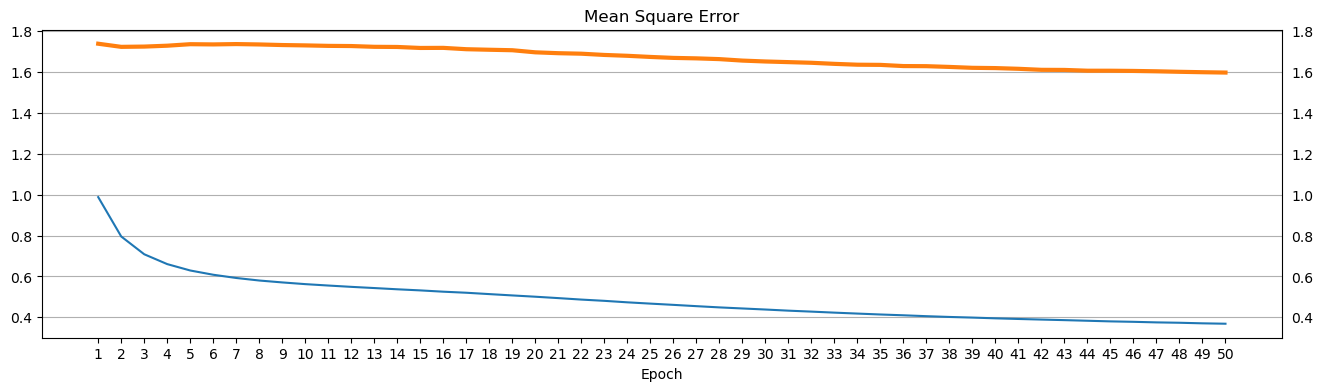

In [43]:
rs.plot_training(train_log)